In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import optuna
import shap

from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

d:\01 Professional software operation\miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

folder_path = 'AD-figure'

# 检查文件夹是否存在，如果不存在则创建它
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹 {folder_path} 已创建。")

In [3]:
# 读取数据，设置指定列的类型
df = pd.read_csv("ADlog_填充.csv",  dtype={'DIPOCE': str, 'BA_Code': str, 'Cata_Code': str})
df

DIPOCE  DI_NCO       PO_HV      PO_f BA_Code  BA_Mn     PO_Phr  \
0    110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
1    110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
2    100010000    31.5  440.000000  3.158698    1000   18.0  50.676157   
3    100100100    31.5  429.326712  3.370281    1000   18.0  32.931727   
4    100100100    31.5  418.118624  3.432704    1000   18.0  30.906059   
..         ...     ...         ...       ...     ...    ...        ...   
288  100010000    31.0  416.000000  2.000000    1000   18.0  73.421439   
289  100010000    31.0  416.000000  2.000000    1000   18.0  80.515298   
290  100010000    31.0  416.000000  2.000000    1000   18.0  84.104289   
291  100010000    31.0  416.000000  2.000000    1000   18.0  85.251492   
292  100010000    31.0  416.000000  2.000000    1000   18.0  86.505190   

       BA_Phr    FS_Phr  Cata_Phr  ...    M_loss      Yield     R        CHS  \
0    2.182432  1.013514  1.013514  ...  5.351351  96.884711  1.83  59.700000   
1    2.182432  1.013514  1.013514  ...  5.351351  96.884711  1.83  59.700000   
2    1.494662  1.010676  0.455516  ...  5.229893  97.017857  1.10  58.400000   
3    0.975330  0.659782  0.295468  ...  4.215720  97.377587  1.10  63.500000   
4    0.990550  0.617009  0.278488  ...  4.084491  97.428971  1.10  64.600000   
..        ...       ...       ...  ...       ...        ...   ...        ...   
288  2.276065  1.101322  0.367107  ...  5.563713  96.859603  1.10  57.662997   
289  1.328502  1.207729  0.402576  ...  3.247450  98.229830  1.10  55.396967   
290  0.849453  1.261564  0.420521  ...  2.076441  98.887437  1.10  54.317040   
291  0.699062  1.278772  0.426257  ...  1.708819  99.089386  1.10  53.980672   
292  0.527682  1.297578  0.432526  ...  1.289889  99.316662  1.10  53.617811   

     A_Mix_t  AB_Mix_t     Q  Cata_Code       MCS  AD(kg/m3)  
0      81.11       5.3   0.0     100000  108.6000       36.8  
1      81.11       5.3   0.0     100000   94.1000       36.8  
2     120.00      10.0   0.0     100100  310.0000       39.0  
3     120.00      10.0   0.0     100100  220.0000       37.6  
4     120.00      10.0   0.0     100100  210.0000       30.8  
..       ...       ...   ...        ...       ...        ...  
288   103.59       5.0  48.0     100000  219.2185       37.8  
289   125.04       5.0  48.0     100000  217.1510       58.0  
290   119.34       5.0  48.0     100000  211.3560       81.3  
291   117.65       5.0  48.0     100000  202.5670       97.6  
292   119.15       5.0  48.0     100000  194.3480      119.1  

[293 rows x 21 columns]

In [4]:
pad_lengths = {
    'DIPOCE': 10,    # 9位
    'BA_Code': 4,   # 4位
    'Cata_Code': 6  # 6位
}

for col, length in pad_lengths.items():
    df[col] = df[col].astype(str).str.zfill(length)
df

DIPOCE  DI_NCO       PO_HV      PO_f BA_Code  BA_Mn     PO_Phr  \
0    0110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
1    0110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
2    0100010000    31.5  440.000000  3.158698    1000   18.0  50.676157   
3    0100100100    31.5  429.326712  3.370281    1000   18.0  32.931727   
4    0100100100    31.5  418.118624  3.432704    1000   18.0  30.906059   
..          ...     ...         ...       ...     ...    ...        ...   
288  0100010000    31.0  416.000000  2.000000    1000   18.0  73.421439   
289  0100010000    31.0  416.000000  2.000000    1000   18.0  80.515298   
290  0100010000    31.0  416.000000  2.000000    1000   18.0  84.104289   
291  0100010000    31.0  416.000000  2.000000    1000   18.0  85.251492   
292  0100010000    31.0  416.000000  2.000000    1000   18.0  86.505190   

       BA_Phr    FS_Phr  Cata_Phr  ...    M_loss      Yield     R        CHS  \
0    2.182432  1.013514  1.013514  ...  5.351351  96.884711  1.83  59.700000   
1    2.182432  1.013514  1.013514  ...  5.351351  96.884711  1.83  59.700000   
2    1.494662  1.010676  0.455516  ...  5.229893  97.017857  1.10  58.400000   
3    0.975330  0.659782  0.295468  ...  4.215720  97.377587  1.10  63.500000   
4    0.990550  0.617009  0.278488  ...  4.084491  97.428971  1.10  64.600000   
..        ...       ...       ...  ...       ...        ...   ...        ...   
288  2.276065  1.101322  0.367107  ...  5.563713  96.859603  1.10  57.662997   
289  1.328502  1.207729  0.402576  ...  3.247450  98.229830  1.10  55.396967   
290  0.849453  1.261564  0.420521  ...  2.076441  98.887437  1.10  54.317040   
291  0.699062  1.278772  0.426257  ...  1.708819  99.089386  1.10  53.980672   
292  0.527682  1.297578  0.432526  ...  1.289889  99.316662  1.10  53.617811   

     A_Mix_t  AB_Mix_t     Q  Cata_Code       MCS  AD(kg/m3)  
0      81.11       5.3   0.0     100000  108.6000       36.8  
1      81.11       5.3   0.0     100000   94.1000       36.8  
2     120.00      10.0   0.0     100100  310.0000       39.0  
3     120.00      10.0   0.0     100100  220.0000       37.6  
4     120.00      10.0   0.0     100100  210.0000       30.8  
..       ...       ...   ...        ...       ...        ...  
288   103.59       5.0  48.0     100000  219.2185       37.8  
289   125.04       5.0  48.0     100000  217.1510       58.0  
290   119.34       5.0  48.0     100000  211.3560       81.3  
291   117.65       5.0  48.0     100000  202.5670       97.6  
292   119.15       5.0  48.0     100000  194.3480      119.1  

[293 rows x 21 columns]

In [5]:
y = np.log10(df['AD(kg/m3)'])
X = df.drop(["AD(kg/m3)"], axis=1)
X

DIPOCE  DI_NCO       PO_HV      PO_f BA_Code  BA_Mn     PO_Phr  \
0    0110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
1    0110100000    31.0  367.991736  4.464132    1000   18.0  67.567568   
2    0100010000    31.5  440.000000  3.158698    1000   18.0  50.676157   
3    0100100100    31.5  429.326712  3.370281    1000   18.0  32.931727   
4    0100100100    31.5  418.118624  3.432704    1000   18.0  30.906059   
..          ...     ...         ...       ...     ...    ...        ...   
288  0100010000    31.0  416.000000  2.000000    1000   18.0  73.421439   
289  0100010000    31.0  416.000000  2.000000    1000   18.0  80.515298   
290  0100010000    31.0  416.000000  2.000000    1000   18.0  84.104289   
291  0100010000    31.0  416.000000  2.000000    1000   18.0  85.251492   
292  0100010000    31.0  416.000000  2.000000    1000   18.0  86.505190   

       BA_Phr    FS_Phr  Cata_Phr    f(H2O)    M_loss      Yield     R  \
0    2.182432  1.013514  1.013514  0.180000  5.351351  96.884711  1.83   
1    2.182432  1.013514  1.013514  0.180000  5.351351  96.884711  1.83   
2    1.494662  1.010676  0.455516  0.167000  5.229893  97.017857  1.10   
3    0.975330  0.659782  0.295468  0.167000  4.215720  97.377587  1.10   
4    0.990550  0.617009  0.278488  0.167000  4.084491  97.428971  1.10   
..        ...       ...       ...       ...       ...        ...   ...   
288  2.276065  1.101322  0.367107  0.172222  5.563713  96.859603  1.10   
289  1.328502  1.207729  0.402576  0.091667  3.247450  98.229830  1.10   
290  0.849453  1.261564  0.420521  0.056111  2.076441  98.887437  1.10   
291  0.699062  1.278772  0.426257  0.045556  1.708819  99.089386  1.10   
292  0.527682  1.297578  0.432526  0.033889  1.289889  99.316662  1.10   

           CHS  A_Mix_t  AB_Mix_t     Q Cata_Code       MCS  
0    59.700000    81.11       5.3   0.0    100000  108.6000  
1    59.700000    81.11       5.3   0.0    100000   94.1000  
2    58.400000   120.00      10.0   0.0    100100  310.0000  
3    63.500000   120.00      10.0   0.0    100100  220.0000  
4    64.600000   120.00      10.0   0.0    100100  210.0000  
..         ...      ...       ...   ...       ...       ...  
288  57.662997   103.59       5.0  48.0    100000  219.2185  
289  55.396967   125.04       5.0  48.0    100000  217.1510  
290  54.317040   119.34       5.0  48.0    100000  211.3560  
291  53.980672   117.65       5.0  48.0    100000  202.5670  
292  53.617811   119.15       5.0  48.0    100000  194.3480  

[293 rows x 20 columns]

In [6]:
params = {'iterations':1400,
            'depth': 6,
            'learning_rate': 0.012,
            'l2_leaf_reg': 2.8,
            'bagging_temperature': 0.43,
            'border_count': 178,
      }

In [7]:
cb_params = params

In [8]:
# 定义评估函数（无 RSE）
def evaluate_model(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return  mae, mse, rmse

# 存储每一折的结果
results = []

kf = KFold(n_splits=3, shuffle=True, random_state=42)

predictions = []
actuals = []
indices = []

for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostRegressor(**cb_params, verbose=0, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_pred_train = model.predict(X_train)

    predictions.append(y_pred_val)
    actuals.append(y_val)
    indices.append(y_val.index)

    n_features = X.shape[1]
    mae_train, mse_train, rmse_train = evaluate_model(y_train, y_pred_train, n_features)
    mae_val, mse_val, rmse_val = evaluate_model(y_val, y_pred_val, n_features)
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)

    results.append({
        'Fold': fold,

        'r2_train': r2_train,
        'r2_val': r2_val,
        'mae_train': mae_train,
        'mae_val': mae_val,
        'mse_train': mse_train,
        'mse_val': mse_val,
        'rmse_train': rmse_train,
        'rmse_val': rmse_val
    })

# 汇总结果表
df_results = pd.DataFrame(results)
mean_results = df_results.mean(numeric_only=True)
mean_results['Fold'] = 'Mean'
df_results = pd.concat([df_results, pd.DataFrame([mean_results])], ignore_index=True)

# 合并预测结果
all_predictions = np.concatenate(predictions)
all_actuals = np.concatenate(actuals)
all_indices = np.concatenate(indices)

df_pred = pd.DataFrame({
    'Index': all_indices,
    'Actual': all_actuals,
    'Predicted': all_predictions
}).sort_values('Index').reset_index(drop=True)

df_results

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30100\1763238600.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_results['Fold'] = 'Mean'


Fold  r2_train    r2_val  mae_train   mae_val  mse_train   mse_val  \
0     1  0.990739  0.836262   0.014045  0.042878   0.000311  0.003966   
1     2  0.993051  0.821144   0.011598  0.046730   0.000220  0.005008   
2     3  0.992686  0.795817   0.011033  0.055432   0.000191  0.007837   
3  Mean  0.992159  0.817741   0.012225  0.048347   0.000241  0.005604   

   rmse_train  rmse_val  
0    0.017647  0.062977  
1    0.014818  0.070770  
2    0.013822  0.088525  
3    0.015429  0.074091

In [9]:
# 计算每个指标的均值 ± 标准差
cols = df_results.drop('Fold', axis=1).columns
mean = df_results[cols].mean()
std = df_results[cols].std()
result = mean.round(2).astype(str) + ' ± ' + std.round(2).astype(str)

# 输出结果
print(result)

r2_train       0.99 ± 0.0
r2_val        0.82 ± 0.02
mae_train      0.01 ± 0.0
mae_val       0.05 ± 0.01
mse_train       0.0 ± 0.0
mse_val        0.01 ± 0.0
rmse_train     0.02 ± 0.0
rmse_val      0.07 ± 0.01
dtype: object


In [10]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 用训练集训练模型
final_model = CatBoostRegressor(**cb_params, verbose=0, random_state=42)
final_model.fit(X_train, y_train)

# 预测训练集和测试集
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# 计算评估指标函数
def evaluate(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return r2, mae, rmse

n_features = X.shape[1]
r2_train,  mae_train, rmse_train = evaluate(y_train, y_pred_train, n_features)
r2_test,  mae_test, rmse_test = evaluate(y_test, y_pred_test, n_features)

# 打印结果
print("训练集指标：")
print(f"R²: {r2_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}")
print("测试集指标：")
print(f"R²: {r2_test:.2f},  MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}")


训练集指标：
R²: 0.99, MAE: 0.01, RMSE: 0.02
测试集指标：
R²: 0.87,  MAE: 0.04, RMSE: 0.06


In [11]:
import joblib

# 保存模型到本地（.joblib格式）
joblib.dump(final_model, "F:/codes/00-WORK/work-1/01-myself/01-predict/01-model/AD.joblib")  
np.save("F:/codes/00-WORK/work-1/01-myself/01-predict/01-plot/AD.npy", y.to_numpy())


In [12]:
all_actuals =10**all_actuals
all_predictions = 10**all_predictions

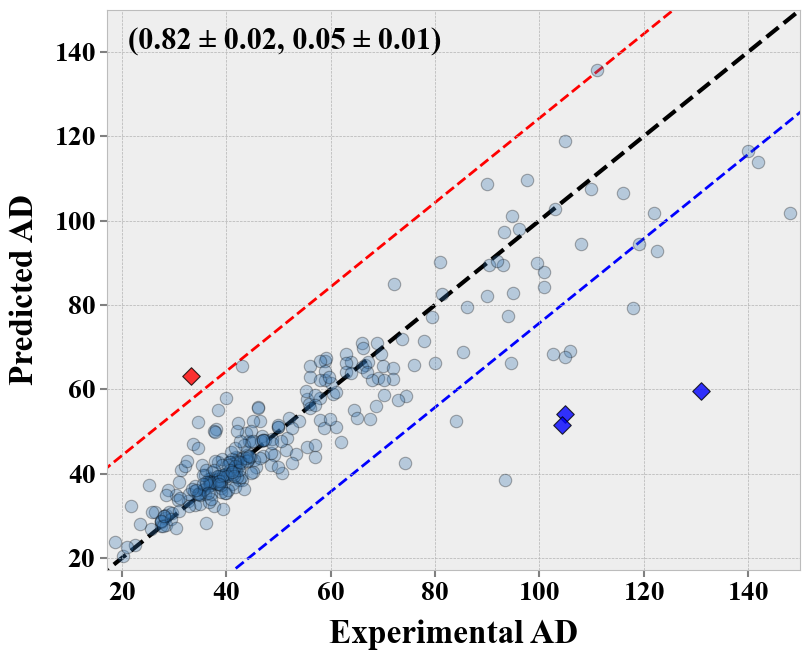

In [13]:
# 计算误差
errors = np.abs(all_predictions - all_actuals)

# 按误差降序排序索引（最大误差在最后）
sorted_idx = np.argsort(errors)

# 指定你要高亮的“误差排名”
selected_ranks = [0, 2, 3, 11] 

# 获取对应的点索引（去重）
highlight_idx = list({sorted_idx[-(r + 1)] for r in selected_ranks})

# 其他点索引
others_idx = np.setdiff1d(np.arange(len(all_actuals)), highlight_idx)

# 构建理想线
sigma = np.std(all_actuals)
# 构建理想线的x和y值
min_val = min(all_actuals.min(), all_predictions.min())
max_val = max(all_actuals.max(), all_predictions.max())
# 设置理想线和偏差带用的横坐标范围，覆盖整个图像范围
x_vals = np.linspace(min_val - 20, max_val + 20, 100)
y_vals = x_vals
ci_upper = y_vals + 1.0 * sigma
ci_lower = y_vals - 1.0 * sigma

# 绘图
plt.figure(figsize=(8.5, 7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.style.use('bmh')

# 偏差带线和理想线
plt.plot(x_vals, ci_upper, color='red', linestyle='--', linewidth=2, zorder=1, label='±1.5σ upper')
plt.plot(x_vals, ci_lower, color='blue', linestyle='--', linewidth=2, zorder=1, label='±1.5σ lower')
plt.plot(x_vals, y_vals, 'k--', lw=3, zorder=1, label='Ideal: y = x')

# 画其他点（不在top3）
plt.scatter(all_actuals[others_idx], all_predictions[others_idx],  
            alpha=0.3, marker='o', color="#3574B1", 
            edgecolors='black', linewidths=0.8, s=80, zorder=2)
# 分别画 highlight_idx 中在上方和下方的点
existing_labels = set()
for i in highlight_idx:
    if all_predictions[i] > all_actuals[i]:
        color = 'red'
        label = 'Top error (above)'
    else:
        color = '#0000FF'
        label = 'Top error (below)'

    # 避免图例重复
    label = label if label not in existing_labels else None
    if label:
        existing_labels.add(label)

    plt.scatter(all_actuals[i], all_predictions[i],
                color=color, marker='D', edgecolors='black', alpha=0.8,
                linewidths=0.8, s=80, zorder=3, label=label)
# R² 和 RMSE 注释
plt.text(0.03, 0.93, f'({result["r2_val"]}, {result["mae_val"]})',
         fontsize=22, transform=plt.gca().transAxes)

# 标签和样式
plt.xlabel('Experimental AD', weight='bold', fontsize=24, labelpad=10)
plt.ylabel('Predicted AD', weight='bold', fontsize=24, labelpad=10)
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight='bold')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1.5,
                color='gray', bottom=True, top=False, left=True, right=False)

# 坐标范围一致
min_val = min(all_actuals.min(), all_predictions.min())
max_val = max(all_actuals.max(), all_predictions.max())
plt.xlim(min_val - 1.5, max_val + 2)
plt.ylim(min_val - 1.5, max_val + 2)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'AD-预测结果.png'), dpi=600)
plt.show()


In [14]:
df_errors = pd.DataFrame({
    'Index': all_indices,
    'Actual': all_actuals,
    'Predicted': all_predictions
})
df_errors['Residuals'] = df_errors['Actual'] - df_errors['Predicted']
df_errors['Abs_Residuals'] = np.abs(df_errors['Residuals'])

# 排序
df_sorted = df_errors.sort_values(by='Abs_Residuals', ascending=False)
df_sorted.head(15)

Index  Actual   Predicted  Residuals  Abs_Residuals
210     47  131.00   59.534299  71.465701      71.465701
167    204   93.50   38.612336  54.887664      54.887664
239    131  104.30   51.662890  52.637110      52.637110
237    129  105.00   54.189261  50.810739      50.810739
84     259  148.00  101.735715  46.264285      46.264285
190    265  118.00   79.253338  38.746662      38.746662
243    149  105.00   67.574894  37.425106      37.425106
216     54  106.00   69.066610  36.933390      36.933390
47     119  102.56   68.434565  34.125435      34.125435
208     43   84.00   52.433166  31.566834      31.566834
44     114   74.20   42.649862  31.550138      31.550138
220     71   33.30   63.260067 -29.960067      29.960067
291    287  122.50   92.718178  29.781822      29.781822
215     53   94.60   66.217709  28.382291      28.382291
199      8  142.00  114.015986  27.984014      27.984014

In [15]:
df_top_actual = df.loc[df_sorted['Index'].head(15)]
df_top_actual

DIPOCE  DI_NCO       PO_HV      PO_f BA_Code       BA_Mn      PO_Phr  \
47   0110000000   31.25  450.000000  4.498111    1000   18.000000   77.869976   
204  0100010000   31.40  495.000000  6.000000    1000   18.000000   84.434500   
131  0100101001   31.20  252.342011  3.979733    1001   48.042145   95.617287   
129  0110001001   31.20  502.876343  5.084942    1001   43.532926   56.281459   
259  0110000010   31.00  450.000000  3.000000    1000   18.000000   56.497175   
265  1010000000   30.80  440.000000  3.000000    0000    0.000000   84.745763   
149  0110000000   31.25  300.000000  2.000000    0001  148.100000  126.000000   
54   0100100000   31.25  431.860292  3.521546    1000   18.000000   68.060338   
119  0100100000   31.50  444.200000  4.338506    1000   18.000000   84.331087   
43   0111000000   32.60  408.046904  4.777913    1000   18.000000   79.772169   
114  0110010000   32.60  370.000000  3.870321    1000   18.000000   60.000000   
71   0110000000   31.00  400.000000  3.720204    0101  116.542403   84.277734   
287  0110000000   31.00  405.000000  6.000000    1000   18.000000   87.108014   
53   0100100000   31.25  440.544633  3.589259    1000   18.000000   64.719667   
8    0100010000   31.40  537.000000  4.666223    1000   18.000000    1.500000   

        BA_Phr    FS_Phr  Cata_Phr  ...     M_loss       Yield       R  \
47    1.491281  1.557400  3.114799  ...   3.806977   97.932110  1.0500   
204   1.688690  0.422173  1.477604  ...   4.127909   97.804572  1.3000   
131  22.769917  1.955561  3.964800  ...  25.719548   89.019482  1.1000   
129   1.623665  1.539496  1.432050  ...   3.224009   98.073049  1.1000   
259   0.225989  1.186441  0.225989  ...   0.552417   99.658000  1.0500   
265   0.000000  1.694915  0.423729  ...   0.000000  100.000000  1.1000   
149  10.600000  1.900000  1.000000  ...  10.567937   95.589559  1.1000   
54   11.152255  2.200507  3.588869  ...  20.811240   96.281976  1.0500   
119   1.830000  1.601058  1.191693  ...   4.468820   98.458250  1.0500   
43    1.800000  1.600000  2.000000  ...   4.342105   98.168193  1.1000   
114   0.830000  0.151000  0.830000  ...   2.024766   98.750516  1.0600   
71    8.252521  1.548249  0.958552  ...   9.365705   95.480015  1.2131   
287   0.757840  1.306620  1.393728  ...   1.852497   99.027898  1.1000   
53   10.588702  2.267450  3.602244  ...  22.733313   96.224954  1.0500   
8     0.060000  0.025000  0.010000  ...  14.666667   94.348105  0.7000   

           CHS  A_Mix_t  AB_Mix_t           Q  Cata_Code      MCS  AD(kg/m3)  
47   56.935369    15.00     12.37     0.00000     100100  311.290     131.00  
204  54.219791    94.05     10.00   336.00000     100000  103.000      93.50  
131  46.935000    11.00     14.00     0.00000     011010  756.340     104.30  
129  62.830982    11.00     14.00     0.00000     011010  435.027     105.00  
259  63.898917   120.00     30.00    48.00000     100000  150.000     148.00  
265  54.128440   311.55     10.00  1128.00000     100000  367.000     118.00  
149  44.200000   528.00     30.00     0.00000     100000  352.000     105.00  
54   47.090340    15.00     15.46     0.00000     100100  370.000     106.00  
119  35.400000   120.00     10.00   561.60000     011000  216.477     102.56  
43   54.400000    10.00     10.00    18.50000     101000  254.250      84.00  
114  63.800000    82.91      8.00    23.50000     100000  427.000      74.20  
71   54.063745   120.00      9.00   274.85038     100000  247.000      33.30  
287  53.445065    69.84      5.00    48.00000     100000  187.851     122.50  
53   46.962903    15.00     15.82     0.00000     100100  248.000      94.60  
8    60.000000    35.00     35.00   436.80000     010000  306.090     142.00  

[15 rows x 21 columns]

In [16]:
df = pd.read_csv("ADlog_填充.csv")
X = df.drop(["AD(kg/m3)"], axis=1)
# 创建一个SHAP解释器
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap_values
expected_value = explainer.expected_value
expected_value

np.float64(1.6720544764805663)

In [17]:
import shap
import os
import matplotlib.pyplot as plt

# 设置字体和样式
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('default')

# 创建主图
fig, ax1 = plt.subplots(figsize=(25, 8), dpi=1200)

# 蜂巢图（dot plot）
feature_names = [name.replace("f(H2O)", r"f(H$_2$O)") for name in X.columns]
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="dot", show=False, color_bar=False, max_display=19)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 调整位置为主图 ax1
ax1 = plt.gca()

# 顶部条形图（bar plot）
ax2 = ax1.twiny()
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar", show=False, max_display=19)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 确保对齐
for bar in ax2.patches:
    # bar.set_facecolor("skyblue")
    bar.set_alpha(0.2)

# 添加灰色参考线
ax2.axhline(y=19, color='black', linestyle='-', linewidth=2)

# 坐标轴标签设置,新罗马字体
ax1.set_xlabel('Shapley Value Contribution', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')
ax1.set_ylabel('Features', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')

ax2.set_xlabel('Mean (|Shapley Value|)', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# 设置刻度字体大小和粗细
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

for label in ax2.get_xticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')
# 边框
for spine in ['left',  'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# 刻度线
ax1.tick_params(axis='both', direction='out', colors='black', width=1.5, length=5)
ax2.tick_params(axis='x', direction='out', colors='black', width=1.5, length=5)
# 设定主坐标轴的x轴范围（根据你的数据调整）
ax1.set_xlim(-0.08, 0.12)
ax2.set_xlim(0, 0.03)
ax1.set_xticks(np.linspace(-0.08, 0.12, 6))
ax2.set_xticks(np.linspace(0, 0.033, 4))
# 调整排版，保存并展示
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'AD_SHAP.png'), dpi=600, bbox_inches='tight')
plt.show()
